## Strategy Combination

This notebook creates a parent strategy(combined) with 2 child strategies(Equal Weight, Inv Vol).

Alternatively, it creates the 2 child strategies, runs the backtest, combines the results, and creates a parent strategy using both of the backtests. 

In [1]:
# add quantkit to path
import sys
from pathlib import Path

d = Path().resolve().parent.parent
sys.path.insert(0, str(d))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantkit.bt as bt
import quantkit.bt.frequency as frequency
import quantkit.bt.signals as signals
import quantkit.bt.portfolio_management as portfolio_management
import quantkit.bt.risk_management as risk_management
import quantkit.bt.weighting_schemes as weighting_schemes
import quantkit.bt.util as util

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

### Create fake data

In [3]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05, scale=0.02, size=5) + rf
sigmas = (mus - rf) / 0.3 + np.random.normal(loc=0.0, scale=0.01, size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year * num_days_per_month

rdf = pd.DataFrame(
    index=pd.date_range(
        start="2008-01-02",
        periods=num_years * num_months_per_year * num_days_per_month,
        freq="B",
    ),
    columns=["foo", "bar", "baz", "fake1", "fake2"],
)

for i, mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:, i] = np.random.normal(
        loc=mu / num_days_per_year,
        scale=sigma / np.sqrt(num_days_per_year),
        size=rdf.shape[0],
    )
pdf = np.cumprod(1 + rdf) * 100
pdf.iloc[0, :] = 100

In [4]:
strategy_names = np.array(["Equal Weight", "Inv Vol"])

runMonthlyAlgo = frequency.RunMonthly(run_on_first_date=True, run_on_end_of_period=True)
selectAllAlgo = signals.SelectAll()
rebalanceAlgo = portfolio_management.Rebalance()

strats = []
tests = []

children = [bt.Security(name) for name in pdf.columns]

for i, s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = weighting_schemes.EqualWeight()
    elif s == "Inv Vol":
        wAlgo = weighting_schemes.InvVolWeight()

    strat = bt.Strategy(
        str(s),
        algos=[runMonthlyAlgo, selectAllAlgo, wAlgo, rebalanceAlgo],
        children=children,
    )
    strats.append(strat)

    t = bt.Backtest(
        strat,
        pdf,
        integer_positions=False,
    )
    tests.append(t)

In [5]:
combined_strategy = bt.Strategy(
    "Combined",
    algos=[
        runMonthlyAlgo,
        selectAllAlgo,
        weighting_schemes.EqualWeight(),
        rebalanceAlgo,
    ],
    children=[x.strategy for x in tests],
)

combined_test = bt.Backtest(combined_strategy, pdf, integer_positions=False)

res = bt.run(combined_test)

In [6]:
res.get_data()

,price,value,notional_value,cash,fees,flows
2008-01-01,100.000000,1.000000e+06,0.000000e+00,1.000000e+06,0.0,1000000.0
2008-01-02,100.000000,1.000000e+06,0.000000e+00,0.000000e+00,0.0,0.0
2008-01-03,99.798381,9.979838e+05,4.979838e+05,0.000000e+00,0.0,0.0
2008-01-04,99.534459,9.953446e+05,4.953446e+05,0.000000e+00,0.0,0.0
2008-01-07,99.409682,9.940968e+05,4.940968e+05,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...
2017-08-23,351.706122,3.517061e+06,3.517066e+06,-1.591616e-10,0.0,0.0
2017-08-24,350.818265,3.508183e+06,3.508187e+06,-1.591616e-10,0.0,0.0
2017-08-25,351.530049,3.515300e+06,3.515305e+06,-1.591616e-10,0.0,0.0
2017-08-28,350.757509,3.507575e+06,3.507580e+06,-1.591616e-10,0.0,0.0


In [7]:
res.get_weights()

,Combined,Combined>Equal Weight,Combined>Equal Weight>foo,Combined>Equal Weight>bar,Combined>Equal Weight>baz,Combined>Equal Weight>fake1,Combined>Equal Weight>fake2,Combined>Inv Vol,Combined>Inv Vol>foo,Combined>Inv Vol>bar,Combined>Inv Vol>baz,Combined>Inv Vol>fake1,Combined>Inv Vol>fake2
2008-01-01,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-02,1.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-03,1.0,0.498990,0.099272,0.099294,0.099719,0.099931,0.100774,0.501010,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-04,1.0,0.497661,0.099074,0.097710,0.099463,0.099712,0.101702,0.502339,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-07,1.0,0.497031,0.098642,0.098886,0.099041,0.099340,0.101121,0.502969,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-23,1.0,0.498236,0.092285,0.100176,0.101348,0.101126,0.102938,0.501764,0.050593,0.095045,0.121748,0.164361,0.070381
2017-08-24,1.0,0.498381,0.092058,0.099752,0.101291,0.100986,0.103931,0.501619,0.050468,0.094642,0.121679,0.164135,0.071060
2017-08-25,1.0,0.498251,0.091828,0.099325,0.102563,0.100606,0.103566,0.501749,0.050342,0.094237,0.123207,0.163517,0.070810
2017-08-28,1.0,0.497882,0.091790,0.099220,0.102502,0.101325,0.102681,0.502118,0.050321,0.094138,0.123134,0.164685,0.070205


In [8]:
res.get_security_weights()

,foo,bar,baz,fake1,fake2
2008-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-03,0.099272,0.099294,0.099719,0.099931,0.100774
2008-01-04,0.099074,0.097710,0.099463,0.099712,0.101702
2008-01-07,0.098642,0.098886,0.099041,0.099340,0.101121
...,...,...,...,...,...
2017-08-23,0.142878,0.195222,0.223096,0.265487,0.173319
2017-08-24,0.142526,0.194394,0.222969,0.265121,0.174991
2017-08-25,0.142169,0.193562,0.225770,0.264123,0.174377
2017-08-28,0.142111,0.193358,0.225637,0.266010,0.172886


In [9]:
res.get_positions()

,foo,bar,baz,fake1,fake2
2008-01-01,0.000000,0.00000,0.00000,0.000000,0.000000
2008-01-02,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
2008-01-03,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
2008-01-04,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
2008-01-07,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
...,...,...,...,...,...
2017-08-23,857.005641,1851.85609,7492.43606,3447.789516,767.466483
2017-08-24,857.005641,1851.85609,7492.43606,3447.789516,767.466483
2017-08-25,857.005641,1851.85609,7492.43606,3447.789516,767.466483
2017-08-28,857.005641,1851.85609,7492.43606,3447.789516,767.466483


<Axes: >

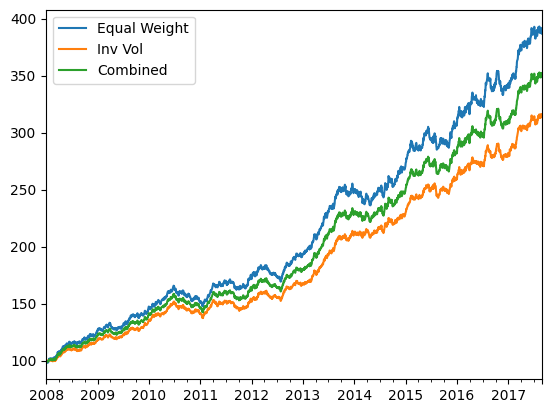

In [10]:
df_prices = pd.concat([res.get_universe(), res.prices], axis=1)
df_prices.plot()